In [1]:
# import necessary modules
# uncomment to get plots displayed in notebook
%matplotlib inline
import matplotlib
import matplotlib.pyplot as plt
import numpy as np
from classy_sz import Class
from scipy.optimize import fsolve
from scipy.interpolate import interp1d
import math

In [2]:
# esthetic definitions for the plots
font = {'size'   : 16, 'family':'STIXGeneral'}
axislabelfontsize='large'
matplotlib.rc('font', **font)
matplotlib.mathtext.rcParams['legend.fontsize']='medium'
plt.rcParams["figure.figsize"] = [8.0,6.0]

In [3]:
import nemo as nm

# From Matt's files to class_sz selection function format

In [2]:
path_to_catalogue = '/Users/boris/Work/CLASS-SZ/SO-SZ/so_cluster_counts/MFMF_WebSkyHalos_A10tSZ_3freq_tiles_pass2/MFMF_WebSkyHalos_A10tSZ_3freq_tiles/'
path_to_selfn = '/Users/boris/Work/CLASS-SZ/SO-SZ/so_cluster_counts/MFMF_WebSkyHalos_A10tSZ_3freq_tiles_pass2/MFMF_WebSkyHalos_A10tSZ_3freq_tiles_pass2/selFn/'
Qfits  = path_to_selfn + 'QFit.fits'

In [3]:
from astropy.io import fits
#"fits_image_filename = fits.util.get_testdata_filepath(path_to_catalogue+'MFMF_SOSim_3freq_tiles_M500.fits')
tcat = path_to_catalogue+'MFMF_WebSkyHalos_A10tSZ_3freq_tiles_mass.fits'
list = fits.open(tcat)
data = list[1].data
z = data.field("redshift")
snr = data.field("SNR")
tile = data.field("tileName")




In [14]:
list = fits.open('/Users/boris/Downloads/unmaskedareafrac-flag.fits')

list[0].header
data = list[0].data

len(data)

50331648

In [15]:
list[0].header

SIMPLE  =                    T / conforms to FITS standard                      
BITPIX  =                  -64 / array data type                                
NAXIS   =                    1 / number of array dimensions                     
NAXIS1  =             50331648                                                  
EXTEND  =                    T                                                  

In [6]:
# SO RMS data
import os

In [7]:
# path_to_selfn = '/Users/boris/Work/CLASS-SZ/SO-SZ/class_sz_external_data_and_scripts/MFMF_SOSim_3freq_tiles/selFn/'
RMS_table = path_to_selfn +'RMSTab.fits'
tile_area = np.genfromtxt(os.path.join(path_to_selfn, 'tileAreas.txt'), dtype=str)

In [8]:
list = fits.open(RMS_table)
data = list[1].data

In [9]:
list[1].header

XTENSION= 'BINTABLE'           / binary table extension                         
BITPIX  =                    8 / array data type                                
NAXIS   =                    2 / number of array dimensions                     
NAXIS1  =                   23 / length of dimension 1                          
NAXIS2  =                61197 / length of dimension 2                          
PCOUNT  =                    0 / number of group parameters                     
GCOUNT  =                    1 / number of groups                               
TFIELDS =                    3 / number of table fields                         
TTYPE1  = 'areaDeg2'                                                            
TFORM1  = 'D       '                                                            
TTYPE2  = 'y0RMS   '                                                            
TFORM2  = 'D       '                                                            
TTYPE3  = 'tileName'        

In [10]:
skyfracs = data.field("areaDeg2")
noise = data.field("y0RMS")
tname = data.field("tileName")
tilename = tile_area[:,0]
np.size(tilename)
skyfracs.size

61197

In [11]:
# downsampling
skyfracs0 = []
noise0 = []
tname0 = []

downsample = 50
stepSize = downsample*1e-7
binEdges = np.arange(min(noise), max(noise)+stepSize, stepSize)
#print(len(binEdges)-1)

for i in range(len(tilename)):
     noise_tile = []
     skyfracs_tile = []
     tname_tile = []

     for j in range(len(noise)):
         if tname[j] == tilename[i]:
             noise_tile.append(noise[j])
             skyfracs_tile.append(skyfracs[j])
             tname_tile.append(tname[j])

     noise_arr = np.array(noise_tile)
     skyfracs_arr = np.array(skyfracs_tile)
     tname_arr = np.array(tname_tile)

     skyfracs_masked = []
     noise_masked = []
     tname_masked = []

     for k in range(len(binEdges)-1):
         mask = np.logical_and(noise_arr >= binEdges[k], noise_arr < binEdges[k+1])
         if mask.sum() > 0:
             noise_masked.append(np.average(noise_arr[mask], weights=skyfracs_arr[mask]))
             skyfracs_masked.append(np.sum(skyfracs_arr[mask]))
             tname_masked.append(tilename[i])

     noise0.append(noise_masked)
     skyfracs0.append(skyfracs_masked)
     tname0.append(tname_masked)

#print(len(noise0))
noise = np.array([item for singleList in noise0 for item in singleList])
skyfracs = np.array([item for singleList in skyfracs0 for item in singleList])*np.deg2rad(1.)**2.
tname_reduced = np.array([item for singleList in tname0 for item in singleList])

tname = []

for i in range(len(tname_reduced)):
    for j in range(len(tilename)):
        if tname_reduced[i] == tilename[j]:
            tname.append(j+1)

tname = np.array(tname)

print("\r Noise map is downsampled to speed up a completeness compuation by %d" %downsample)
print("\r Number of sky patches = ", skyfracs.size)


print("\r Entire survey area = ", skyfracs.sum()/(np.deg2rad(1.)**2.), "deg2")



 Noise map is downsampled to speed up a completeness compuation by 50
 Number of sky patches =  451
 Entire survey area =  17884.522553016595 deg2


In [75]:
list = fits.open(Qfits)
data = list[1].data
list[1].header

XTENSION= 'BINTABLE'           / binary table extension                         
BITPIX  =                    8 / array data type                                
NAXIS   =                    2 / number of array dimensions                     
NAXIS1  =                   24 / length of dimension 1                          
NAXIS2  =                   51 / length of dimension 2                          
PCOUNT  =                    0 / number of group parameters                     
GCOUNT  =                    1 / number of groups                               
TFIELDS =                    3 / number of table fields                         
NEMOVER = '0.4.0b3+120.g542317d.dirty'                                          
ZDEPQ   =                    0                                                  
EXTNAME = '1_0_0   '           / extension name                                 
TTYPE1  = 'Q       '                                                            
TFORM1  = 'D       '        

In [76]:
# Nt = len(tilename)
# print("\r Number of tiles = ", Nt)


# list = fits.open(Qfits)
# data = list[1].data
# tt500 = data.field("theta500Arcmin")

# # reading in all Q functions
# allQ = np.zeros((len(tt500),Nt))
# for i in range(Nt):
# #     allQ[:,i] = data.field(tilename[i])
#     allQ[:,i] = data.field('Q') # seems like only one Q function
# assert len(tt500) == len(allQ[:,0])


# # meanQ = np.delete(allQ, np.s_[103,328], axis=1) # manually for now
# meanQ = allQ
# Q = np.mean(meanQ, axis=1)
# print("\r Number of Q functions = ", Q.ndim)
# print("\r Using one averaged Q function for optimisation")



 Number of tiles =  346
 Number of Q functions =  1
 Using one averaged Q function for optimisation


In [77]:
QFit = nm.signals.QFit(QFitFileName = path_to_selfn + 'QFit.fits', tileNames = tile_area[:,0])

In [78]:
Nt = len(tilename)
print("\r Number of tiles = ", Nt)


list = fits.open(Qfits)
data = list[1].data
tt500 = data.field("theta500Arcmin")

# reading in all Q functions
allQ = np.zeros((len(tt500),Nt))
for i in range(Nt):
#     allQ[:,i] = data.field(tilename[i])
#     allQ[:,i] = data.field('Q') # seems like only one Q function
    allQ[:,i] = QFit.getQ(data.field("theta500Arcmin"),tileName = tile_area[:,0][i])
assert len(tt500) == len(allQ[:,0])


# meanQ = np.delete(allQ, np.s_[103,328], axis=1) # manually for now
meanQ = allQ
Q = np.mean(meanQ, axis=1)
print("\r Number of Q functions = ", Q.ndim)
print("\r Using one averaged Q function for optimisation")



 Number of tiles =  346
 Number of Q functions =  1
 Using one averaged Q function for optimisation


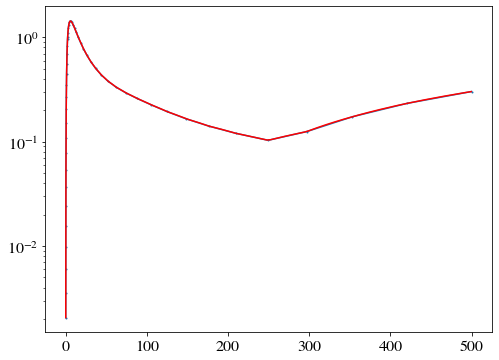

In [79]:
plt.plot(tt500,Q,marker='o',markersize=1.)
plt.yscale('log')
import scipy
Q_interp = scipy.interpolate.interp1d(tt500,Q)
new_th = np.geomspace(1.0001*(tt500.min()),0.999*(tt500.max()),500)
plt.plot(new_th,Q_interp(new_th),c='r')
Q_new_th = Q_interp(new_th)

In [80]:
rad_in_deg2 = (np.deg2rad(1.))**2.
np.savetxt(path_to_catalogue+'so_3freqs_120921_pass2_theta500arcmin_Q.txt',np.c_[tt500,Q])

np.savetxt(path_to_catalogue+'so_3freqs_120921_pass2_skyfracs.txt',np.c_[skyfracs/rad_in_deg2/41253.])

In [81]:
# plc_skyfracs = np.loadtxt('/Users/boris/Work/CLASS-SZ/SO-SZ/class_sz/sz_auxiliary_files/SZ_skyfracs.txt')
so_skyfracs = np.loadtxt(path_to_catalogue+'so_3freqs_120921_pass2_skyfracs.txt')

In [34]:
# plc_ylims = np.loadtxt('/Users/boris/Work/CLASS-SZ/SO-SZ/class_sz/sz_auxiliary_files/SZ_ylims.txt')

In [82]:
so_ylims = []
for index_thetas in range(Q.size):
    for id_patches in range(so_skyfracs.size):
        so_ylims.append(noise[id_patches]/Q[index_thetas])
so_ylims = np.asarray(so_ylims)
np.savetxt(path_to_catalogue+'so_3freqs_120921_pass2_ylims.txt',np.c_[so_ylims])
np.savetxt(path_to_catalogue+'so_3freqs_120921_pass2_thetas.txt',np.c_[tt500])

In [13]:
len(noise)

451

In [59]:
so_ylims = []
for index_thetas in range(Q_new_th.size):
    for id_patches in range(so_skyfracs.size):
        so_ylims.append(noise[id_patches]/Q_new_th[index_thetas])
so_ylims = np.asarray(so_ylims)
np.savetxt(path_to_catalogue+'so_3freqs_020621_ylims_fine.txt',np.c_[so_ylims])
np.savetxt(path_to_catalogue+'so_3freqs_020621_thetas_fine.txt',np.c_[new_th])

In [58]:
so_skyfracs.sum()

0.43213469173544644

# Read in the catalogue

In [35]:
path_to_catalogue = '/Users/boris/Work/CLASS-SZ/SO-SZ/class_sz_external_data_and_scripts/MFMF_SOSim_3freq_tiles/'

In [36]:
from astropy.io import fits
#"fits_image_filename = fits.util.get_testdata_filepath(path_to_catalogue+'MFMF_SOSim_3freq_tiles_M500.fits')
tcat = path_to_catalogue+'MFMF_SOSim_3freq_tiles_M500.fits'
list = fits.open(tcat)
data = list[1].data
z = data.field("redshift")
snr = data.field("SNR")
tile = data.field("tileName")




In [37]:
print(data.columns)

ColDefs(
    name = 'name'; format = '18A'
    name = 'RADeg'; format = 'D'
    name = 'decDeg'; format = 'D'
    name = 'SNR'; format = 'D'
    name = 'numSigPix'; format = 'D'
    name = 'template'; format = '17A'
    name = 'tileName'; format = '7A'
    name = 'galacticLatDeg'; format = 'D'
    name = 'fixed_SNR'; format = 'D'
    name = 'deltaT_c'; format = 'D'
    name = 'err_deltaT_c'; format = 'D'
    name = 'y_c'; format = 'D'
    name = 'err_y_c'; format = 'D'
    name = 'fixed_deltaT_c'; format = 'D'
    name = 'fixed_err_deltaT_c'; format = 'D'
    name = 'fixed_y_c'; format = 'D'
    name = 'fixed_err_y_c'; format = 'D'
    name = 'redshift'; format = 'D'
    name = 'redshiftErr'; format = 'D'
    name = 'M500'; format = 'D'
    name = 'M500_errPlus'; format = 'D'
    name = 'M500_errMinus'; format = 'D'
    name = 'M500Uncorr'; format = 'D'
    name = 'M500Uncorr_errPlus'; format = 'D'
    name = 'M500Uncorr_errMinus'; format = 'D'
    name = 'M200m'; format = 'D'
    name

In [6]:
snrcut = 5
z = z[snr > snrcut]
snr = snr[snr > snrcut]

np.shape(z)
np.log(snrcut)

1.6094379124341003

In [7]:
z.max()

2.769250813231601

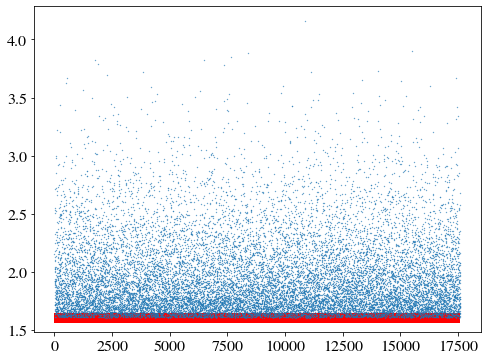

In [8]:
plt.plot(np.log(snr),marker='o',ls='None',markersize=0.3)
plt.hlines(np.log(snrcut),xmin=0,xmax=len(snr),color='r',lw=10)

In [9]:
# redshift bins
dz = 0.1
z_min = 0.
z_max = 2.8

In [10]:
(z_max-z_min)/dz

27.999999999999996

In [11]:
nbins_z = int( np.floor((z_max-z_min)/dz) + 1)
nbins_z += 1
nbins_z

29

In [12]:
z_bin_edges = np.zeros(nbins_z+1)
z_bin_edges[0] = z_min
for i in range(1,nbins_z):
    z_bin_edges[i] = z_bin_edges[i-1]+dz
z_bin_edges[nbins_z] = z_max+dz
z_bin_centers = np.zeros(nbins_z)
for i in range(0,nbins_z):
    z_bin_centers[i] = z_bin_edges[i]+(z_bin_edges[i+1]-z_bin_edges[i])/2.
z_bin_centers

array([0.05, 0.15, 0.25, 0.35, 0.45, 0.55, 0.65, 0.75, 0.85, 0.95, 1.05,
       1.15, 1.25, 1.35, 1.45, 1.55, 1.65, 1.75, 1.85, 1.95, 2.05, 2.15,
       2.25, 2.35, 2.45, 2.55, 2.65, 2.75, 2.85])

In [13]:
N_clusters_z, xedges = np.histogram(z, bins=z_bin_edges)

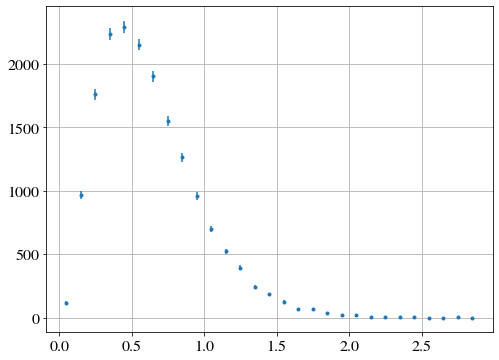

In [14]:
plt.errorbar(z_bin_centers,N_clusters_z,yerr=np.sqrt(N_clusters_z),marker='o',markersize=3.,ls='none')
plt.grid()

In [15]:
np.log10(32.)

1.505149978319906

In [16]:
# snr bins
dlnsnr = 0.1
lnsnr_min = np.log10(snrcut)
lnsnr_max = np.log10(snr.max()+1.)

In [17]:
lnsnr_min

0.6989700043360189

In [18]:
lnsnr_max

1.8124259665302023

In [19]:
nbins_lnsnr = int( np.floor((lnsnr_max-lnsnr_min)/dlnsnr) + 1)
nbins_lnsnr

12

In [20]:
lnsnr_bin_edges = np.zeros(nbins_lnsnr+2)
lnsnr_bin_edges[0] = lnsnr_min 
for i in range(1,nbins_lnsnr+2):
    lnsnr_bin_edges[i] = lnsnr_bin_edges[i-1]+dlnsnr
# lnsnr_bin_edges[nbins_lnsnr] = lnsnr_max + dlnsnr
lnsnr_bin_centers = np.zeros(nbins_lnsnr+1)
for i in range(0,nbins_lnsnr+1):
    lnsnr_bin_centers[i] = lnsnr_bin_edges[i]+dlnsnr/2.
10**lnsnr_bin_centers

array([ 5.61009227,  7.06268772,  8.89139705, 11.19360569, 14.09191466,
       17.74066946, 22.33417961, 28.11706626, 35.39728922, 44.56254691,
       56.10092272, 70.62687723, 88.9139705 ])

In [21]:
lnsnr_bin_edges

array([0.69897, 0.79897, 0.89897, 0.99897, 1.09897, 1.19897, 1.29897,
       1.39897, 1.49897, 1.59897, 1.69897, 1.79897, 1.89897, 1.99897])

In [22]:
N_clusters_lnsnr, xedges = np.histogram(np.log10(snr), bins=lnsnr_bin_edges)
N_clusters_lnsnr

array([8756, 4234, 2242, 1209,  608,  308,  126,   72,   28,   11,    0,
          1,    0])

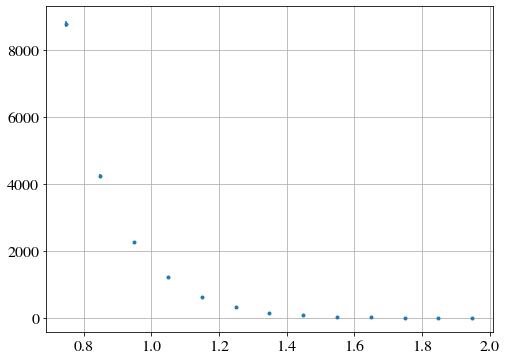

In [23]:
plt.errorbar(lnsnr_bin_centers,N_clusters_lnsnr,yerr=np.sqrt(N_clusters_lnsnr),marker='o',markersize=3.,ls='none')
plt.grid()

In [24]:
N_clusters_lnsnr.sum()

17595

In [25]:
# SO RMS data
import os

In [38]:
path_to_selfn = '/Users/boris/Work/CLASS-SZ/SO-SZ/class_sz_external_data_and_scripts/MFMF_SOSim_3freq_tiles/selFn/'
RMS_table = path_to_selfn +'RMSTab.fits'
tile_area = np.genfromtxt(os.path.join(path_to_selfn, 'tileAreas.txt'), dtype=str)

In [39]:
list = fits.open(RMS_table)
data = list[1].data

In [40]:
skyfracs = data.field("areaDeg2")
noise = data.field("y0RMS")
tname = data.field("tileName")
tilename = tile_area[:,0]
np.size(tilename)
skyfracs.size

61256

In [29]:
full_area_deg2 = np.sum(skyfracs)

In [30]:
# downsampling
skyfracs0 = []
noise0 = []
tname0 = []

downsample = 50
stepSize = downsample*1e-7
binEdges = np.arange(min(noise), max(noise)+stepSize, stepSize)
#print(len(binEdges)-1)

for i in range(len(tilename)):
     noise_tile = []
     skyfracs_tile = []
     tname_tile = []

     for j in range(len(noise)):
         if tname[j] == tilename[i]:
             noise_tile.append(noise[j])
             skyfracs_tile.append(skyfracs[j])
             tname_tile.append(tname[j])

     noise_arr = np.array(noise_tile)
     skyfracs_arr = np.array(skyfracs_tile)
     tname_arr = np.array(tname_tile)

     skyfracs_masked = []
     noise_masked = []
     tname_masked = []

     for k in range(len(binEdges)-1):
         mask = np.logical_and(noise_arr >= binEdges[k], noise_arr < binEdges[k+1])
         if mask.sum() > 0:
             noise_masked.append(np.average(noise_arr[mask], weights=skyfracs_arr[mask]))
             skyfracs_masked.append(np.sum(skyfracs_arr[mask]))
             tname_masked.append(tilename[i])

     noise0.append(noise_masked)
     skyfracs0.append(skyfracs_masked)
     tname0.append(tname_masked)

#print(len(noise0))
noise = np.array([item for singleList in noise0 for item in singleList])
skyfracs = np.array([item for singleList in skyfracs0 for item in singleList])*np.deg2rad(1.)**2.
tname_reduced = np.array([item for singleList in tname0 for item in singleList])

tname = []

for i in range(len(tname_reduced)):
    for j in range(len(tilename)):
        if tname_reduced[i] == tilename[j]:
            tname.append(j+1)

tname = np.array(tname)

print("\r Noise map is downsampled to speed up a completeness compuation by %d" %downsample)
print("\r Number of sky patches = ", skyfracs.size)


print("\r Entire survey area = ", skyfracs.sum()/(np.deg2rad(1.)**2.), "deg2")


 Noise map is downsampled to speed up a completeness compuation by 50
 Number of sky patches =  447
 Entire survey area =  17826.852438162376 deg2


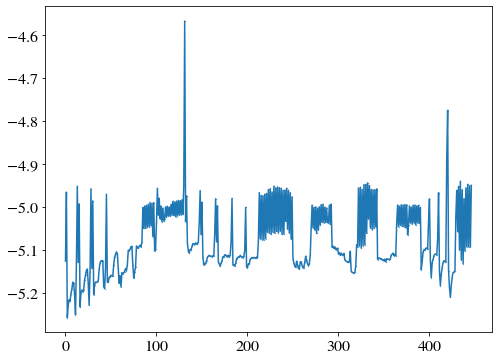

In [31]:
plt.plot(np.log10(noise),marker='o',markersize=0.3)

In [32]:
# Q function

In [15]:
path_to_selfn = '/Users/boris/Work/CLASS-SZ/SO-SZ/class_sz_external_data_and_scripts/MFMF_SOSim_3freq_tiles/selFn/'
Qfits  = path_to_selfn + 'QFit.fits'

In [16]:
Nt = len(tilename)
print("\r Number of tiles = ", Nt)


list = fits.open(Qfits)
data = list[1].data
tt500 = data.field("theta500Arcmin")

 Number of tiles =  346


In [17]:
list[1].header

XTENSION= 'BINTABLE'           / binary table extension                         
BITPIX  =                    8 / array data type                                
NAXIS   =                    2 / number of array dimensions                     
NAXIS1  =                 2776 / length of dimension 1                          
NAXIS2  =                   51 / length of dimension 2                          
PCOUNT  =                    0 / number of group parameters                     
GCOUNT  =                    1 / number of groups                               
TFIELDS =                  347 / number of table fields                         
TTYPE1  = 'theta500Arcmin'                                                      
TFORM1  = 'D       '                                                            
TTYPE2  = '1_0_0   '                                                            
TFORM2  = 'D       '                                                            
TTYPE3  = '1_0_1   '        

In [18]:
Nt = len(tilename)
print("\r Number of tiles = ", Nt)


list = fits.open(Qfits)
data = list[1].data
tt500 = data.field("theta500Arcmin")

# reading in all Q functions
allQ = np.zeros((len(tt500),Nt))
for i in range(Nt):
    allQ[:,i] = data.field(tilename[i])
assert len(tt500) == len(allQ[:,0])


meanQ = np.delete(allQ, np.s_[103,328], axis=1) # manually for now
Q = np.mean(meanQ, axis=1)
print("\r Number of Q functions = ", Q.ndim)
print("\r Using one averaged Q function for optimisation")



 Number of tiles =  346
 Number of Q functions =  1
 Using one averaged Q function for optimisation


In [19]:

print(tilename[0],data.field(tilename[0]))

1_0_0 [0.00194169 0.00337121 0.00570464 0.00939087 0.01505322 0.02348173
 0.03568572 0.05289286 0.07656471 0.10832515 0.14999697 0.20339362
 0.27023019 0.35184962 0.4489453  0.56123983 0.68696171 0.82255091
 0.9624626  1.         1.09920005 1.22384869 1.32757208 1.40231929
 1.44197964 1.44380945 1.40904177 1.34240415 1.25093349 1.14284971
 1.02650094 0.90918586 0.79656061 0.6923414  0.59874906 0.51708411
 0.44758648 0.38950711 0.34143984 0.30122258 0.26586148 0.23255087
 0.20038777 0.17074376 0.14503454 0.12314062 0.15797568 0.22043041
 0.29701337 0.38701687 0.48859193]


In [52]:
list[1].header

XTENSION= 'BINTABLE'           / binary table extension                         
BITPIX  =                    8 / array data type                                
NAXIS   =                    2 / number of array dimensions                     
NAXIS1  =                 2776 / length of dimension 1                          
NAXIS2  =                   51 / length of dimension 2                          
PCOUNT  =                    0 / number of group parameters                     
GCOUNT  =                    1 / number of groups                               
TFIELDS =                  347 / number of table fields                         
TTYPE1  = 'theta500Arcmin'                                                      
TFORM1  = 'D       '                                                            
TTYPE2  = '1_0_0   '                                                            
TFORM2  = 'D       '                                                            
TTYPE3  = '1_0_1   '        

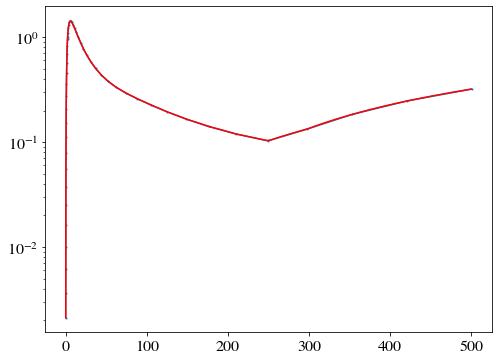

In [55]:
plt.plot(tt500,Q,marker='o',markersize=1.)
plt.yscale('log')
import scipy
Q_interp = scipy.interpolate.interp1d(tt500,Q)
new_th = np.geomspace(1.0001*(tt500.min()),0.999*(tt500.max()),500)
plt.plot(new_th,Q_interp(new_th),c='r')
Q_new_th = Q_interp(new_th)

In [52]:
rad_in_deg2 = (np.deg2rad(1.))**2.
np.savetxt(path_to_catalogue+'so_3freqs_020621_theta500arcmin_Q.txt',np.c_[tt500,Q])

np.savetxt(path_to_catalogue+'so_3freqs_020621_skyfracs.txt',np.c_[skyfracs/rad_in_deg2/41253.])

In [53]:
plc_skyfracs = np.loadtxt('/Users/boris/Work/CLASS-SZ/SO-SZ/class_sz/sz_auxiliary_files/SZ_skyfracs.txt')
so_skyfracs = np.loadtxt('/Users/boris/Work/CLASS-SZ/SO-SZ/class_sz/sz_auxiliary_files/so_3freqs_020621_skyfracs.txt')

In [54]:
plc_ylims = np.loadtxt('/Users/boris/Work/CLASS-SZ/SO-SZ/class_sz/sz_auxiliary_files/SZ_ylims.txt')

In [56]:
so_ylims = []
for index_thetas in range(Q.size):
    for id_patches in range(so_skyfracs.size):
        so_ylims.append(noise[id_patches]/Q[index_thetas])
so_ylims = np.asarray(so_ylims)
np.savetxt(path_to_catalogue+'so_3freqs_020621_ylims.txt',np.c_[so_ylims])
np.savetxt(path_to_catalogue+'so_3freqs_020621_thetas.txt',np.c_[tt500])

In [59]:
so_ylims = []
for index_thetas in range(Q_new_th.size):
    for id_patches in range(so_skyfracs.size):
        so_ylims.append(noise[id_patches]/Q_new_th[index_thetas])
so_ylims = np.asarray(so_ylims)
np.savetxt(path_to_catalogue+'so_3freqs_020621_ylims_fine.txt',np.c_[so_ylims])
np.savetxt(path_to_catalogue+'so_3freqs_020621_thetas_fine.txt',np.c_[new_th])

In [58]:
so_skyfracs.sum()

0.43213469173544644

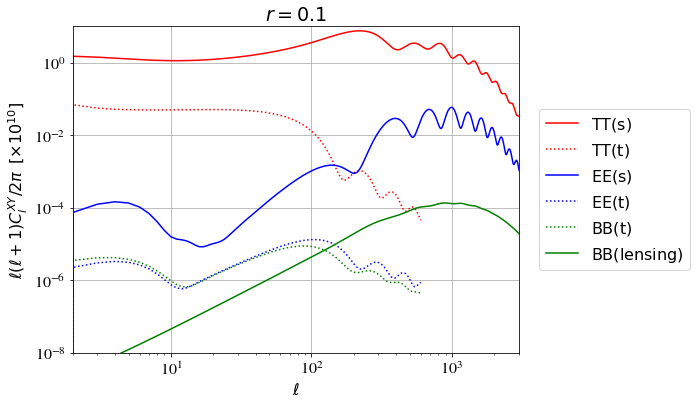

In [6]:
#############################################
#
# Cosmological parameters and other CLASS parameters
#
common_settings = {# wich output? ClTT, transfer functions delta_i and theta_i
                   'output':'tCl,pCl,lCl',
                   # LambdaCDM parameters
                   'h':0.67556,
                   'omega_b':0.022032,
                   'omega_cdm':0.12038,
                   'A_s':2.215e-9,
                   'tau_reio':0.0925,
                   # Take fixed value for primordial Helium (instead of automatic BBN adjustment)
                   'YHe':0.246}
                   # other output and precision parameters
                   #'l_max_scalars':3000}
###############
#    
# call CLASS 
#
###############
#
# scalars only
#
M = Class()
M.set(common_settings)
M.set({'output':'tCl,pCl','modes':'s','lensing':'no','n_s':0.9619,'l_max_scalars':3000})
M.compute()
cls = M.raw_cl(3000)
M.struct_cleanup()
M.empty()
#
# tensors only
#
M = Class()
M.set(common_settings)
l_max_tensors = 600
M.set({'output':'tCl,pCl','modes':'t','lensing':'no','r':0.1,'n_t':0,'l_max_tensors':l_max_tensors})
# for l_max=600 we can keep default precision
# for l_max = 3000 we would need to import many high precision settings from the file cl_ref.pre
#M.set({'output':'tCl,pCl','modes':'t','lensing':'no','r':0.1,'n_t':0,'l_max_tensors':3000})
#M.set({
#'recfast_Nz0':100000,
#'tol_thermo_integration':1.e-5,
#'recfast_x_He0_trigger_delta':0.01,
#'recfast_x_H0_trigger_delta':0.01,
#'evolver':0,
#'k_min_tau0':0.002,
#'k_max_tau0_over_l_max':3.,
#'k_step_sub':0.015,
#'k_step_super':0.0001,
#'k_step_super_reduction':0.1,
#'start_small_k_at_tau_c_over_tau_h':0.0004,
#'start_large_k_at_tau_h_over_tau_k':0.05,
#'tight_coupling_trigger_tau_c_over_tau_h':0.005,
#'tight_coupling_trigger_tau_c_over_tau_k':0.008,
#'start_sources_at_tau_c_over_tau_h':0.006,
#'l_max_g':50,
#'l_max_pol_g':25,
#'l_max_ur':50,
#'tol_perturb_integration':1.e-6,
#'perturb_sampling_stepsize':0.01,
#'radiation_streaming_approximation':2,
#'radiation_streaming_trigger_tau_over_tau_k':240.,
#'radiation_streaming_trigger_tau_c_over_tau':100.,
#'ur_fluid_approximation':2,
#'ur_fluid_trigger_tau_over_tau_k':50.,
#'l_logstep':1.026,
#'l_linstep':25,
#'hyper_sampling_flat':12.,
#'hyper_nu_sampling_step':10.,
#'hyper_phi_min_abs':1.e-10,
#'hyper_x_tol':1.e-4,
#'hyper_flat_approximation_nu':1.e6,
#'q_linstep':0.20,
#'q_logstep_spline':20.,
#'q_logstep_trapzd':0.5,
#'q_numstep_transition':250,
#'transfer_neglect_delta_k_T_t2':100.,
#'transfer_neglect_delta_k_T_e':100.,
#'transfer_neglect_delta_k_T_b':100.,
#'neglect_CMB_sources_below_visibility':1.e-30,
#'transfer_neglect_late_source':3000.
#})
M.compute()
clt = M.raw_cl(l_max_tensors)
M.struct_cleanup()
M.empty()
#
# scalars + tensors (only in this case we can get the correct lensed ClBB)
#
M = Class()
M.set(common_settings)
M.set({'output':'tCl,pCl,lCl','modes':'s,t','lensing':'yes','r':0.1,'n_s':0.9619,'n_t':0,'l_max_scalars':3000,'l_max_tensors':l_max_tensors})
M.compute()
cl_tot = M.raw_cl(3000)
cl_lensed = M.lensed_cl(3000)
M.struct_cleanup()
M.empty()
#
#################
#
# start plotting
#
#################
#
plt.xlim([2,3000])
plt.ylim([1.e-8,10])
plt.xlabel(r"$\ell$")
plt.ylabel(r"$\ell (\ell+1) C_l^{XY} / 2 \pi \,\,\, [\times 10^{10}]$")
plt.title(r"$r=0.1$")
plt.grid()
#
ell = cl_tot['ell']
ellt = clt['ell']
factor = 1.e10*ell*(ell+1.)/2./math.pi
factort = 1.e10*ellt*(ellt+1.)/2./math.pi
#
plt.loglog(ell,factor*cls['tt'],'r-',label=r'$\mathrm{TT(s)}$')
plt.loglog(ellt,factort*clt['tt'],'r:',label=r'$\mathrm{TT(t)}$')
plt.loglog(ell,factor*cls['ee'],'b-',label=r'$\mathrm{EE(s)}$')
plt.loglog(ellt,factort*clt['ee'],'b:',label=r'$\mathrm{EE(t)}$')
plt.loglog(ellt,factort*clt['bb'],'g:',label=r'$\mathrm{BB(t)}$')
plt.loglog(ell,factor*(cl_lensed['bb']-cl_tot['bb']),'g-',label=r'$\mathrm{BB(lensing)}$')
plt.legend(loc='right',bbox_to_anchor=(1.4, 0.5))

In [ ]:
plt.savefig('cl_ST.pdf',bbox_inches='tight')